# My GD/SGD implemenatation

In [130]:
%pylab inline
import pandas as pd
import time

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Для логистической регрессии оптимальный параметр находится минимизацией кросс-энтропии: 

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] $$


Градиент в матричной форме: 

$$ \nabla L = -\frac{1}{\ell} X^T \cdot (y - P) $$ 

In [61]:
def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Время выполнения метода {func.__name__}: {elapsed_time:.4f} секунд")
        return result
    return wrapper

In [62]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic', 
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic' 
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        # self.alpha = alpha
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
    
    @timing_decorator
    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = [0]

        X = np.c_[np.ones(X.shape[0]), X]

        self.w = self.w0 if self.w0 is not None else np.zeros(X.shape[1])

        if self.gd_type == 'stochastic':

            for _ in range(self.max_iter):
                indices = np.random.choice(X.shape[0], size=1)
                X_batch = np.array(X[indices])
                y_batch = np.array(y[indices])
                grad = self.calc_gradient(X_batch, y_batch)
                self.w = self.w - self.eta * grad
                loss = self.calc_loss(X_batch, y_batch)
                self.loss_history.append(loss)

                if abs(loss - self.loss_history[-1]) < self.tolerance:
                    break

        elif self.gd_type == 'full':
            for _ in range(self.max_iter):
                grad = self.calc_gradient(X, y)
                self.w = self.w - self.eta * grad
                loss = self.calc_loss(X, y)
                self.loss_history.append(loss)

                if abs(loss - self.loss_history[-1]) < self.tolerance:
                    break              

        return self
    
    
    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        
        probability = 1 / (1 + np.exp(-np.dot(X, self.w)))
    
        return probability
    
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        
        probability = self.predict_proba(X @ self.w)
        predictions = (probability >= 0.5).astype(int)

        return predictions
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """

        probability = self.predict_proba(X)
        grad = -1 / X.shape[0] * np.dot(X.T, (y - probability))

        return grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 

        probability = self.predict_proba(X)
        loss = - sum(y * np.log(probability) + (1 - y) * np.log(1 - probability)) / y.shape[0]

        return loss


Синтетические данные

In [32]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [202]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [203]:
my_model_first = LogReg()
my_model_first.fit(X_train, y_train)

Время выполнения метода fit: 0.0617 секунд


LogReg()

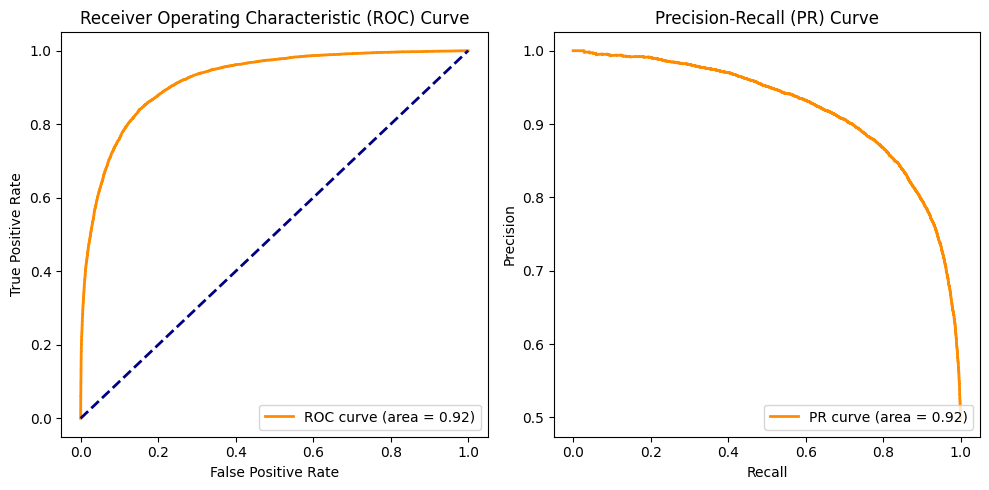

In [204]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt


y_probs = my_model_first.predict_proba(np.c_[np.ones(X_test.shape[0]), X_test])

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


В нашем случае, значения ROC-AUC и PR-AUC равны 0.92, что говорит о высокой способности модели классификации на идеальных синтетических данных.